# Seizure detection sandbox

## Workspace Preparation

In [1]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale

# Data IO imports
import mne
import mne_bids
from mne_bids import BIDSPath, read_raw_bids

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
from seizure_detection_pipeline import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-09-05 18:19:36.962766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 18:19:39.849036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [3]:
set_seed(5210)

In [4]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP238'
montage = 'bipolar'

## Anomaly Detection

### Generating model predictions

(<Figure size 1999.93x2900 with 1 Axes>, <Axes: xlabel='Time (s)'>)

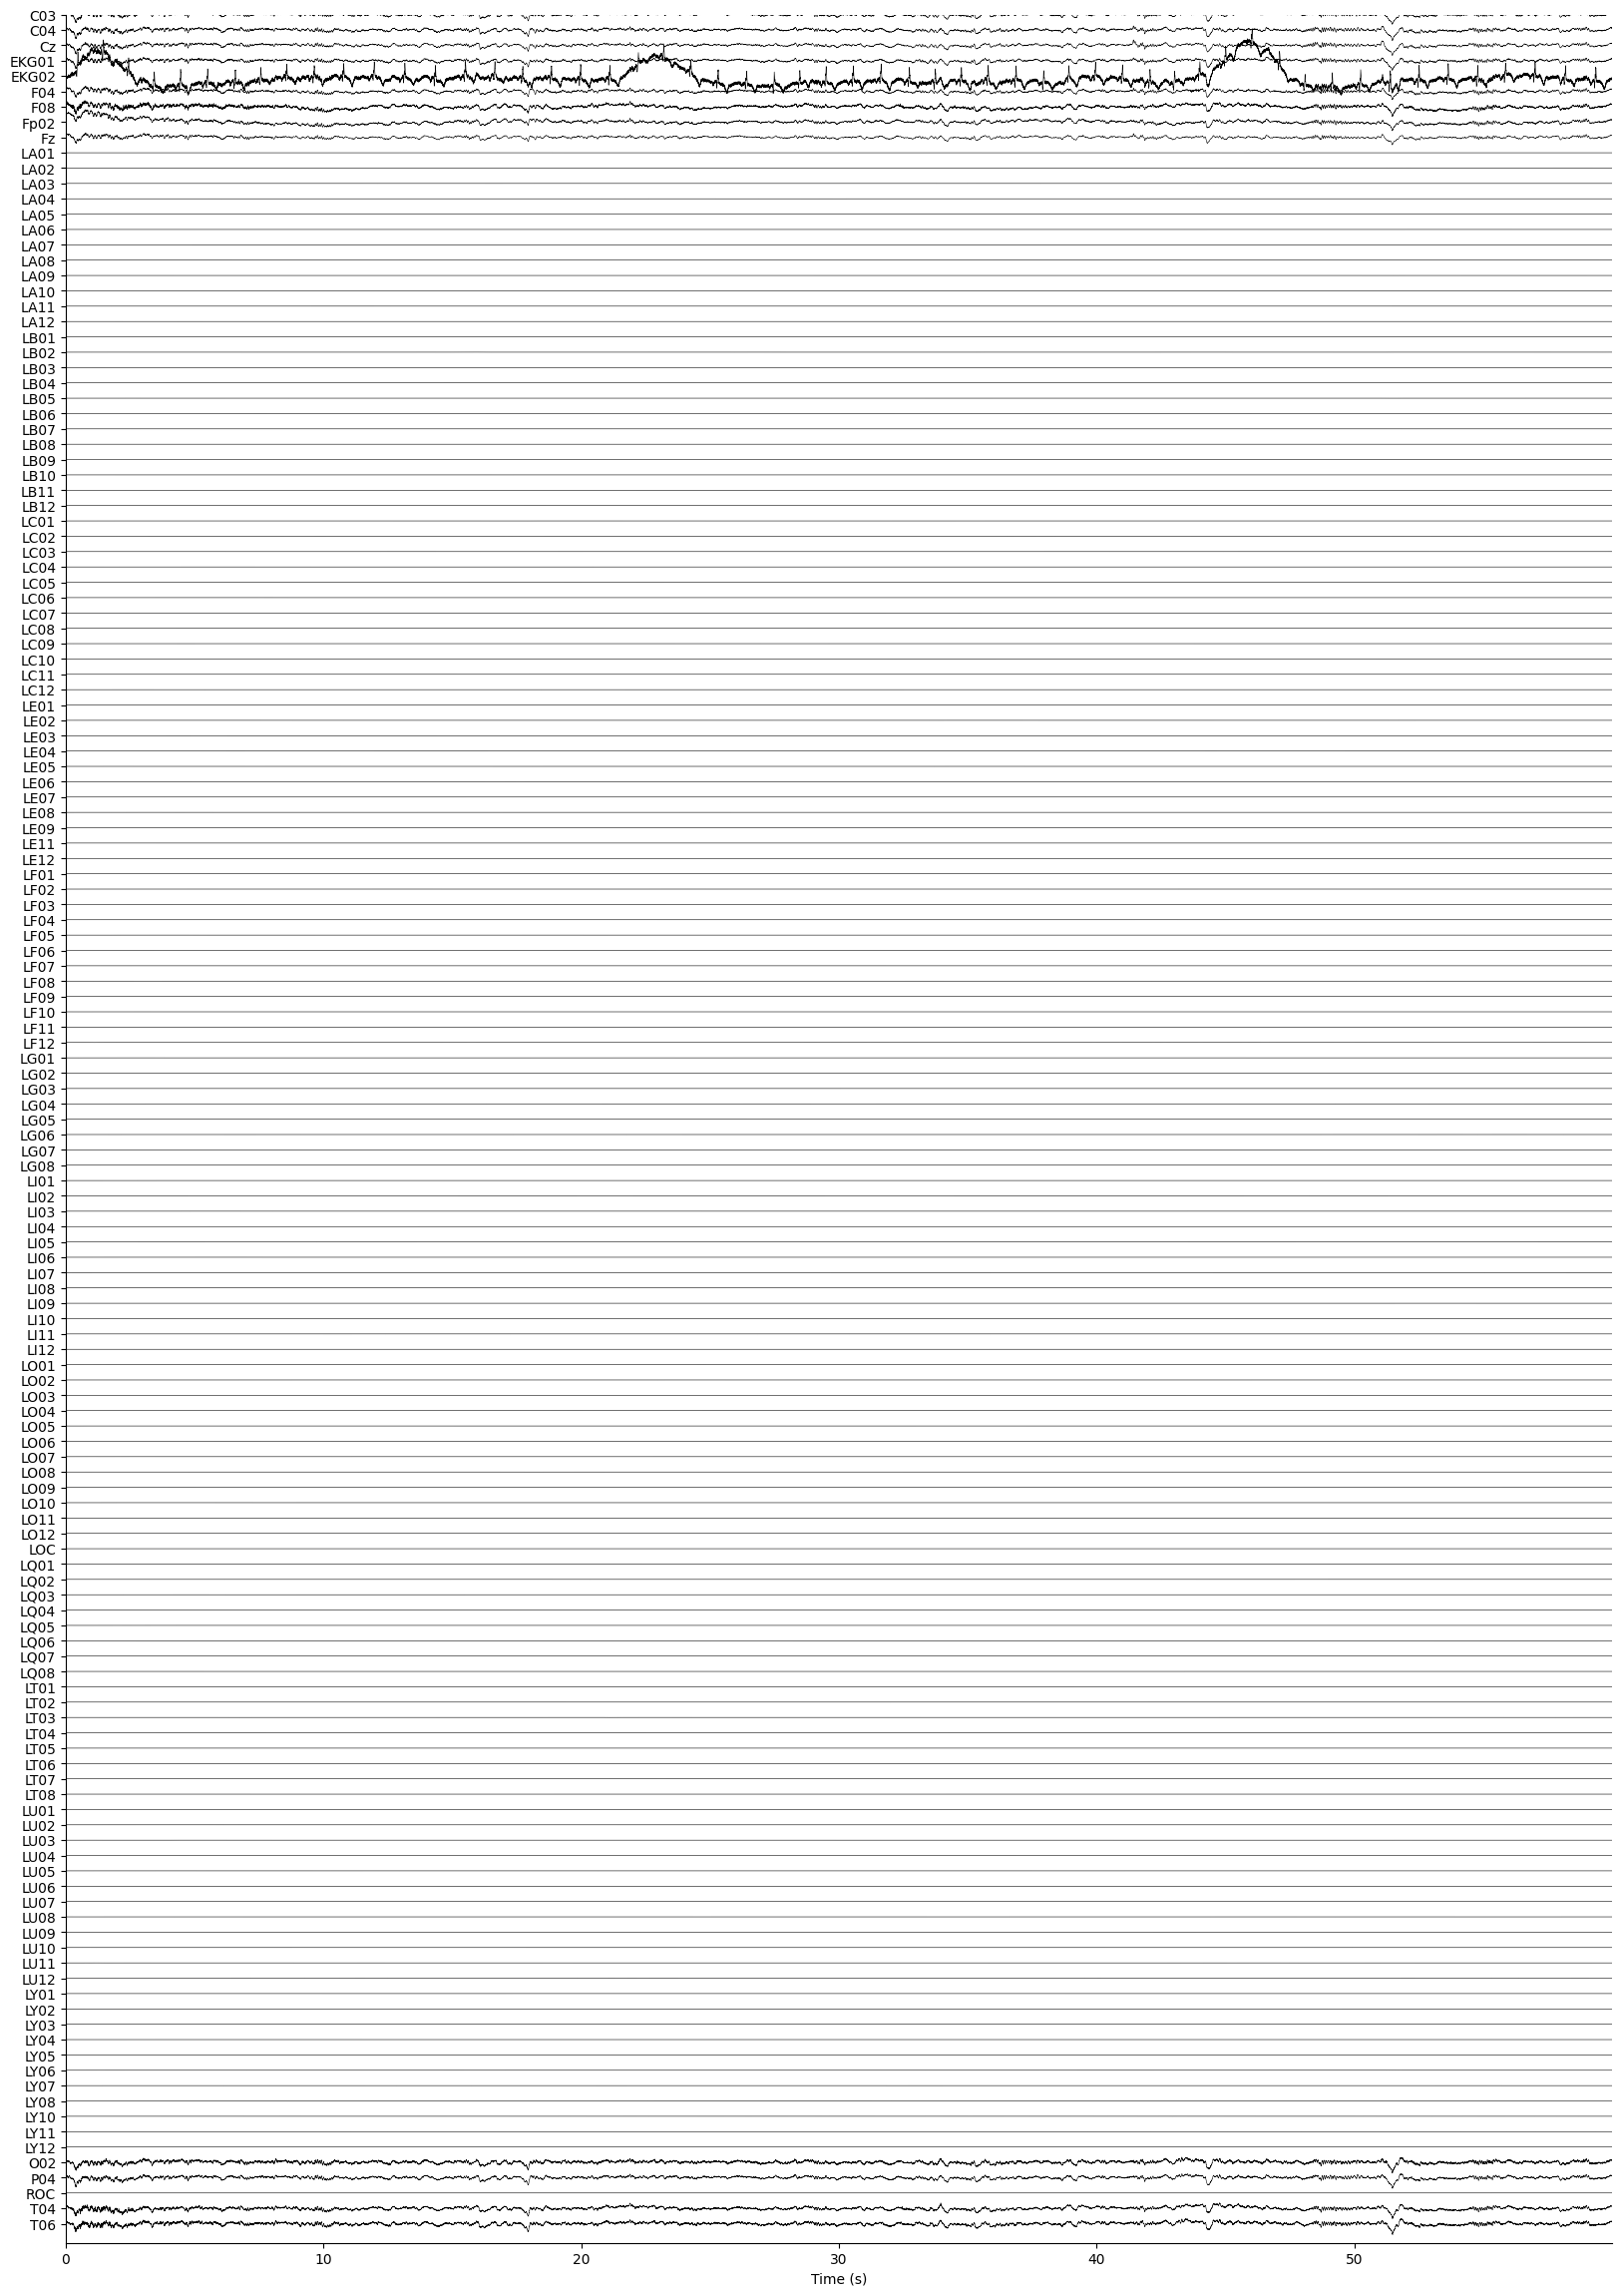

In [5]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [6]:
def remove_scalp_electrodes(raw_labels):
    scalp_list = ['CZ','FZ','PZ',
                  'A01','A02',
                  'C03','C04',
                  'F03','F04','F07','F08',
                  'Fp01','Fp02',
                  'O01','O02',
                  'P03','P04',
                  'T03','T04','T05','T06',
                  'EKG01','EKG02',
                  'ROC','LOC',
                  'EMG01','EMG02',
                  'DC01','DC07'
                  ]
    chop_scalp = ['C1'+str(x) for x in range(19,29)]
    scalp_list += chop_scalp
    return [l for l in raw_labels if l.upper() not in scalp_list]

In [7]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [8]:
try:
    electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    electrode_localizations.name = clean_labels(electrode_localizations.name,pt)
    electrode_regions.name = clean_labels(electrode_regions.name,pt)
    electrode_localizations.to_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
    electrode_regions.to_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
except:
    print(f"electrode localization failed for {pt}")
    neural_channels = chn_labels
inter_neural = inter.loc[:,neural_channels]
# plot_iEEG_data(inter_neural,np.arange(len(inter_neural))/fs_raw)

In [9]:
inter_prep,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

In [10]:
# plot_iEEG_data(inter,np.arange(len(inter))/fs)
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [11]:
model = NRG(1,.5,128)
model.fit(inter_prep)

In [12]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [13]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=2:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    break

In [14]:
task

'ictal294225'

In [15]:
# plot_iEEG_data(seizure_raw,np.arange(len(seizure_raw))/fs_raw)

In [16]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [17]:
seizure_prep,fs = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=128)

In [18]:
seizure_prep.shape

(47615, 69)

(<Figure size 12399.5x1380 with 1 Axes>, <Axes: xlabel='Time (s)'>)

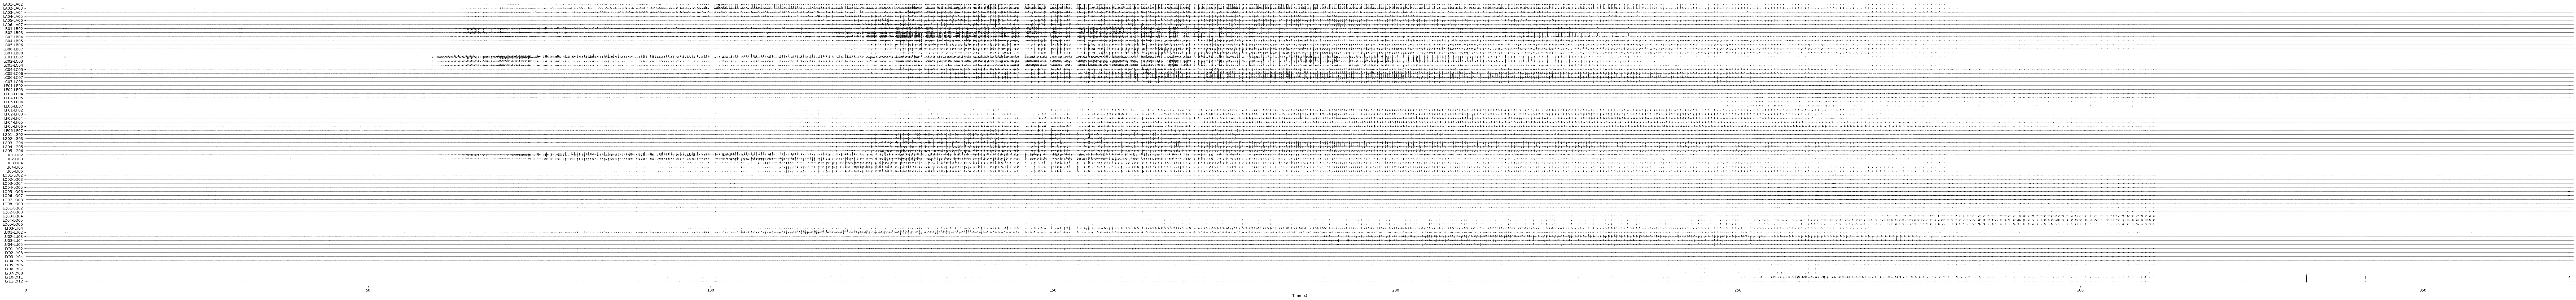

In [19]:
plot_iEEG_data(pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns),
np.arange(len(seizure_prep))/fs)

In [20]:
preds = model(seizure_prep)
preds_smooth = sc.ndimage.uniform_filter1d(preds,20,axis=1)

([], [])

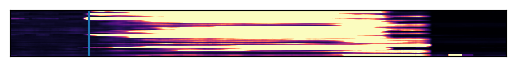

In [23]:
plt.imshow(preds_smooth)
plt.clim([0,1])
tiks = np.arange(0,preds_smooth.shape[1],50)
times = model.get_times(seizure_prep)
plt.xticks(tiks,times[tiks].astype(int))
plt.axvline(np.argmin(np.abs(times-60)))
plt.xticks([])
plt.yticks([])

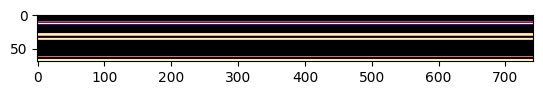

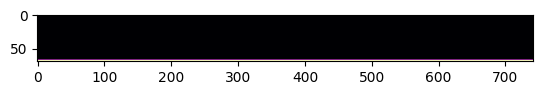

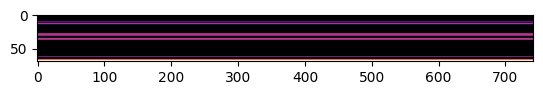

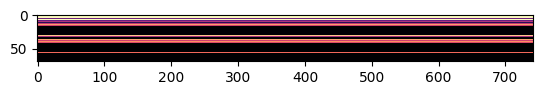

In [23]:
ch_mask_early = np.zeros_like(preds_smooth)
ch_mask_late = np.zeros_like(preds_smooth)
ch_mask_all = np.zeros_like(preds_smooth)
early = np.sum(preds_smooth[:,:118] > .1,axis=1) > 30
late = np.sum(preds_smooth[:,-118:] > .1,axis=1) > 30
all_mask = np.sum(preds_smooth > 0.75,axis=1) > preds_smooth.shape[1]/2
ch_mask_early[early,:] = 1
ch_mask_late[late,:] = 1
ch_mask_all[all_mask,:] = 1
plt.imshow(ch_mask_early)
plt.figure()
plt.imshow(ch_mask_late)
plt.figure()
plt.imshow(ch_mask_early + ch_mask_late)
plt.figure()
plt.imshow(ch_mask_all)

In [24]:
print(seizure_prep.columns[early])
print(seizure_prep.columns[late])

Index(['LB06-LB07', 'LC01-LC02', 'LC02-LC03', 'LF03-LF04', 'LF04-LF05',
       'LF05-LF06', 'LF06-LF07', 'LG04-LG05', 'LG05-LG06', 'LI01-LI02',
       'LY03-LY04', 'LY07-LY08', 'LY10-LY11', 'LY11-LY12'],
      dtype='object')
Index(['LY10-LY11', 'LY11-LY12'], dtype='object')


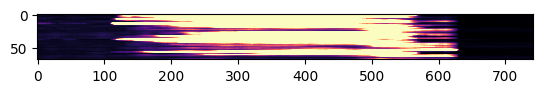

In [25]:
preds_smooth_reject = preds_smooth[~late,:]
plt.imshow(preds_smooth_reject)
plt.clim(0,1)

In [26]:
onset_chs_list = []
for t in np.arange(0,1,.01):
    late = np.sum(preds_smooth[:,-118:] > t,axis=1) > 30
    preds_smooth_reject = preds_smooth[~late,:]
    onset_ch_idxs = np.all(preds_smooth_reject[:,118:123]>t,axis=1)
    sz_chs = seizure_prep.columns[~late]
    onset_chs = sz_chs[onset_ch_idxs]
    onset_chs_list.append(onset_chs)

In [27]:
onset_chs_list

[Index([], dtype='object'),
 Index(['LA01-LA02', 'LA02-LA03', 'LA04-LA05', 'LA05-LA06', 'LA06-LA07',
        'LB01-LB02', 'LB02-LB03', 'LB03-LB04', 'LB04-LB05', 'LB05-LB06',
        'LB06-LB07', 'LB07-LB08', 'LC01-LC02', 'LC02-LC03', 'LC03-LC04',
        'LC04-LC05', 'LC05-LC06', 'LC06-LC07', 'LC07-LC08', 'LF02-LF03',
        'LF03-LF04', 'LF04-LF05', 'LF05-LF06', 'LF06-LF07', 'LG01-LG02',
        'LG02-LG03', 'LG03-LG04', 'LG04-LG05', 'LG05-LG06', 'LI03-LI04',
        'LI04-LI05', 'LI05-LI06', 'LQ04-LQ05', 'LQ05-LQ06', 'LT03-LT04',
        'LU02-LU03', 'LU03-LU04', 'LU04-LU05', 'LY01-LY02'],
       dtype='object'),
 Index(['LA01-LA02', 'LA02-LA03', 'LA03-LA04', 'LA04-LA05', 'LA05-LA06',
        'LA06-LA07', 'LB01-LB02', 'LB02-LB03', 'LB03-LB04', 'LB04-LB05',
        'LB05-LB06', 'LB06-LB07', 'LB07-LB08', 'LC01-LC02', 'LC02-LC03',
        'LC03-LC04', 'LC04-LC05', 'LC05-LC06', 'LC06-LC07', 'LC07-LC08',
        'LF02-LF03', 'LF03-LF04', 'LF04-LF05', 'LF05-LF06', 'LF06-LF07',
        'LG

### Measuring dynamic spread

In [28]:
time_wins = model.get_times(seizure_prep)

In [29]:
# To save
# First seizing index at the final threshold after offset
# UEO channels at first seizing index + 3 indices
# Seizing index and time since first seizing index for each channel
t = 0.4
late = np.sum(preds_smooth[:,-120:] > t,axis=1) > 30
preds_smooth_reject = preds_smooth[~late,:]
sz_chs = seizure_prep.columns[~late]
first_sz_idx_offset = 115
sz_clf_final = preds_smooth_reject > t
# Get channels
sliced_data = sz_clf_final[:,first_sz_idx_offset:]
df = pd.DataFrame(sliced_data).T
seizing = df.rolling(window=5,closed='right').apply(lambda x: (x == 1).all())
first_sz_idxs = seizing.idxmax().to_numpy() - 4
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
if sum(seized_idxs) > 0:
    sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
    sz_times_arr -= np.min(sz_times_arr)
    sz_ch_arr = sz_chs[seized_idxs]
    sz_ch_arr = np.array([s.split("-")[0] for s in sz_ch_arr]).flatten()
else:
    sz_ch_arr = []
    sz_times_arr = []

In [30]:
time_wins[first_sz_idxs[seized_idxs]]

array([ 61.,  63.,  62.,  62.,  90.,  86.,  59.,  59.,  61.,  66.,  80.,
       117., 117.,  59.,  59.,  59.,  94.,  89.,  93., 102., 103., 138.,
       101., 101., 245., 240., 108., 106., 109., 111., 113.,  80.,  84.,
        88.,  68.,  81.,  99.,  59.,  61.,  75.,  82.,  83., 129., 127.,
       100., 101., 108., 114., 167., 253.,  94., 142., 219., 133., 100.,
        94.,  60., 165., 116., 159., 118., 127., 193., 255., 270., 257.,
       243.,  97.])

In [32]:
print(time_wins[118],time_wins[140])

60.0 71.0


In [34]:
idxs = np.argsort(sz_times_arr)
print(sz_ch_arr[idxs])

['LB01' 'LB02' 'LI01' 'LC01' 'LC02' 'LC03' 'LU01' 'LA01' 'LB03' 'LI02'
 'LA03' 'LA04' 'LA02' 'LB04' 'LG03' 'LI03' 'LF06' 'LB05' 'LG04' 'LI04'
 'LI05' 'LG01' 'LA06' 'LG02' 'LC05' 'LA05' 'LC06' 'LT03' 'LQ01' 'LC04'
 'LY11' 'LG05' 'LQ05' 'LO03' 'LE04' 'LO04' 'LE03' 'LC07' 'LE01' 'LF02'
 'LO05' 'LF01' 'LF03' 'LF04' 'LF05' 'LO06' 'LU03' 'LB07' 'LB06' 'LY01'
 'LO02' 'LY02' 'LO01' 'LQ04' 'LE02' 'LQ02' 'LU04' 'LU02' 'LO07' 'LY03'
 'LQ03' 'LE06' 'LY07' 'LE05' 'LO08' 'LY04' 'LY06' 'LY05']


Text(0.5, 1.0, 'Seizure spread after onset')

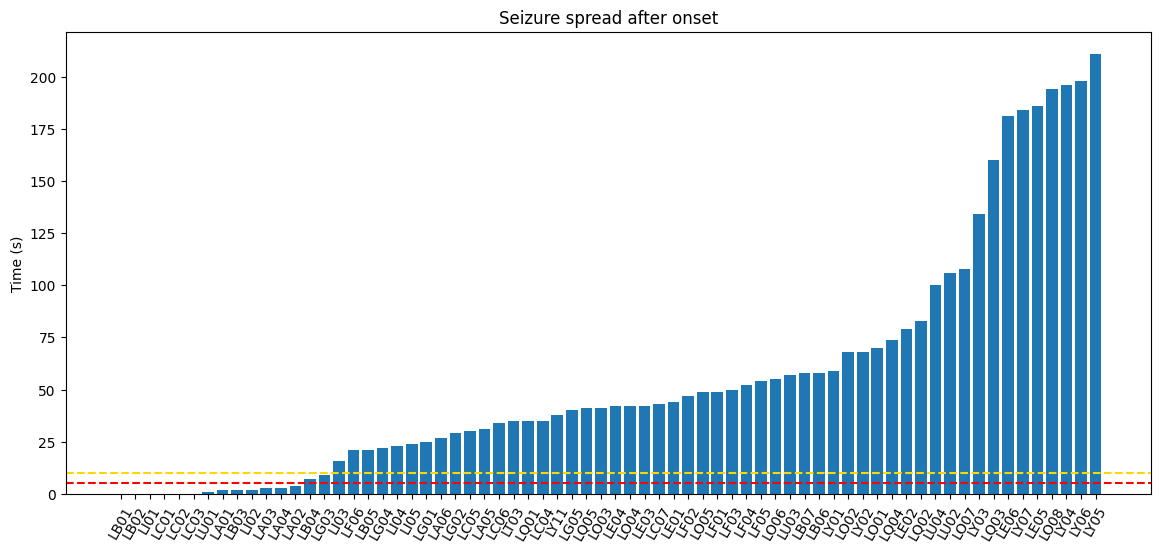

In [47]:
plt.figure(figsize=(14,6))
plt.bar(np.arange(len(idxs)),sz_times_arr[idxs])
plt.xticks(np.arange(len(idxs)),sz_ch_arr[idxs],rotation=60);
plt.axhline(5,ls='--',color='red')
plt.axhline(10,ls='--',color='gold')
plt.ylabel("Time (s)")
plt.title('Seizure spread after onset')

## Deep Learning

In [28]:
 # Instantiate the model
input_size = inter_prep.shape[1]
hidden_size = 10

# Check for cuda
# ccheck = torch.cuda.is_available()
ccheck = False

# Initialize the model
model = LSTMModel(input_size, hidden_size)

# Scale the training data
model.fit_scaler(inter_prep)
inter_z = model.scaler_transform(inter_prep)
inter_z = pd.DataFrame(inter_z,columns=inter_prep.columns)

# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter_z,fs=fs)

dataset = TensorDataset(input_data, target_data)
full_batch = len(dataset)
dataloader = DataLoader(dataset, batch_size=full_batch, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model, this will just modify the model object, no returns
# print("Training patient specific model")
train_model(model,dataloader,criterion,optimizer,ccheck=ccheck)

# Creating classification thresholds
input_data,target_data = prepare_segment(inter_z,fs=fs)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=full_batch,ccheck=ccheck)
thresholds = np.percentile(inter_outputs,75,0)

In [29]:
seizure_z = model.scaler_transform(seizure_prep)
seizure_z = pd.DataFrame(seizure_z,columns=seizure_prep.columns)
input_data, target_data,time_wins = prepare_segment(seizure_z,fs,12,1,ret_time=True)
# Generate seizure detection predictions for each window
outputs = predict_sz(model,input_data,target_data,batch_size=len(input_data)//2,ccheck=ccheck)
seizure_mat = repair_data(outputs,seizure_z,fs=fs)
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.log(seizure_mat),1).T
# Creating classifications
mdl_outs = (raw_sz_vals.T > np.log(thresholds)).T.astype(float)

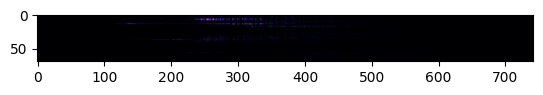

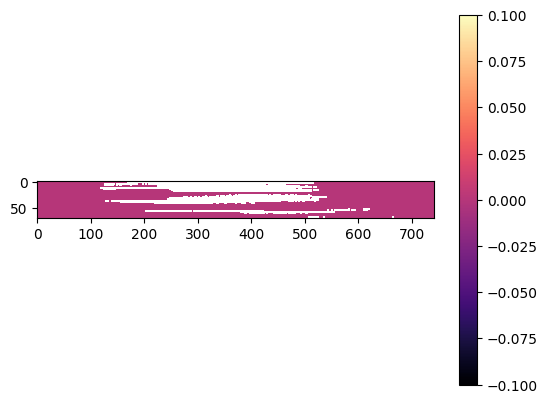

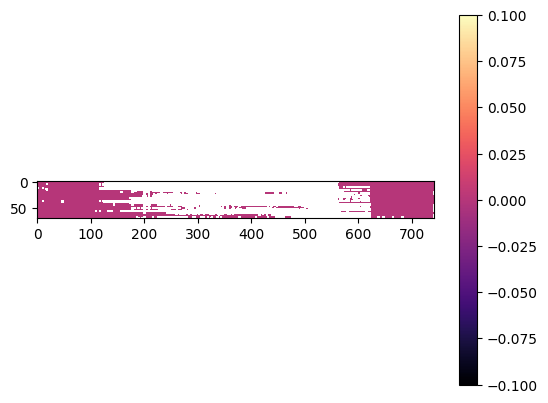

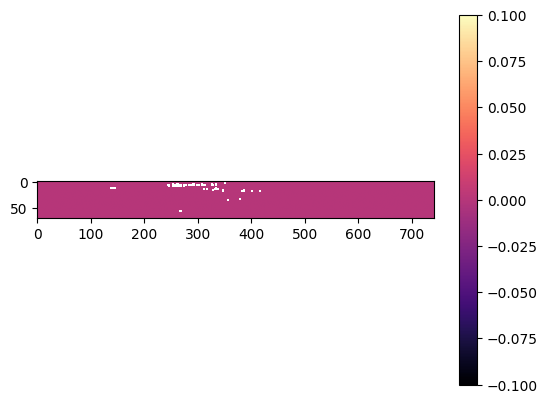

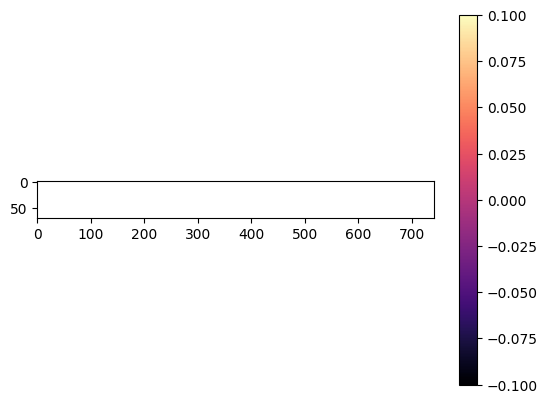

In [49]:
plt.figure()
plt.imshow(np.median(seizure_mat,1).T)
plt.figure()
temp = np.exp(np.mean(seizure_mat,1).T)
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.mean(np.exp(seizure_mat),1).T
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.exp(np.percentile(seizure_mat,75,axis=1).T)
plt.imshow(temp/np.max(temp))
plt.colorbar()
plt.figure()
temp = np.percentile(np.exp(seizure_mat),75,axis=1).T
plt.imshow(temp/np.max(temp))
plt.colorbar()